# EIP-1559 Gas pricing analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set_theme(style="whitegrid")

In [2]:
# EIP1559 configuration
MAX_GAS_PER_BLOCK = 30_000_000
TARGET_GAS_PER_BLOCK = 15_000_000
INITIAL_BASE_FEE = 1_000_000_000
BASE_FEE_MAX_CHANGE_DENOMINATOR = 8
ELASTICITY_MULTIPLIER = 2

# simuplation configuration
TIMESTEMPS = 5 * 60 * 24 * 3
RUNS = 200

In [3]:
def get_base_fee_per_gas(parent_base_fee_per_gas: int, parent_gas_used: int) -> int:
    gas_target = TARGET_GAS_PER_BLOCK
    if parent_gas_used == TARGET_GAS_PER_BLOCK:
        return parent_base_fee_per_gas
    elif parent_gas_used > TARGET_GAS_PER_BLOCK:
        gas_used_delta = parent_gas_used - gas_target
        base_fee_per_gas_delta = max(parent_base_fee_per_gas * gas_used_delta // gas_target // BASE_FEE_MAX_CHANGE_DENOMINATOR, 1)
        return parent_base_fee_per_gas + base_fee_per_gas_delta
    else:
        gas_used_delta = gas_target - parent_gas_used
        base_fee_per_gas_delta = parent_base_fee_per_gas * gas_used_delta // gas_target // BASE_FEE_MAX_CHANGE_DENOMINATOR
        return parent_base_fee_per_gas - base_fee_per_gas_delta

In [4]:
def policy_resource_fee(params, substep, state_history, previous_state):
    get_base_fee_per_gas = params['get_base_fee_per_gas']

    parent_gas_used = previous_state['gas_used']
    parent_base_fee_per_gas = previous_state['base_fee_per_gas']

    base_fee_per_gas = get_base_fee_per_gas(parent_base_fee_per_gas, parent_gas_used)

    return {
        'base_fee_per_gas': base_fee_per_gas,
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    gas_used_process = params['gas_used_process']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    gas_used = gas_used_process(run, timestep)

    return {
        'gas_used': gas_used,
    }

def update_base_fee_per_gas(params, substep, state_history, previous_state, policy_input):
    base_fee_per_gas = policy_input['base_fee_per_gas']
    return ('base_fee_per_gas', base_fee_per_gas)

def update_gas_used(params, substep, state_history, previous_state, policy_input):
    gas_used = policy_input['gas_used']
    return ('gas_used', gas_used)




In [5]:
# Model 1
def gas_used_process(run: int, timesteps: int) -> int:
    rng = np.random.default_rng()
    samples = rng.normal(loc=TARGET_GAS_PER_BLOCK, scale=TARGET_GAS_PER_BLOCK/4, size=1).round().astype(int)
    value = np.minimum(np.maximum(samples,[0]), [MAX_GAS_PER_BLOCK])[0]
    return value

initial_state = {
    'gas_used': 0,
    'base_fee_per_gas': INITIAL_BASE_FEE,
}

state_update_blocks = [
    {
        'policies': {
            'block': policy_resource_fee,
        },
        'variables': {
            'base_fee_per_gas': update_base_fee_per_gas,
        }
    },
    {
        'policies': {
            'block': policy_resource_usage,
        },
        'variables': {
            'gas_used': update_gas_used,
        }
    },
]

params = {
    'get_base_fee_per_gas': [get_base_fee_per_gas],
    'gas_used_process': [gas_used_process],
}

model = Model(
    initial_state=initial_state,
    state_update_blocks=state_update_blocks,
    params=params,
)

simulation = Simulation(
    model=model,
    timesteps=TIMESTEMPS,
    runs=RUNS
)


In [6]:
experiment = Experiment(simulations=[simulation])
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

df = pd.DataFrame(result)
df

,gas_used,base_fee_per_gas,simulation,subset,run,substep,timestep
0,0,1000000000,0,0,1,0,0
1,7481496,875000000,0,0,1,2,1
2,16209161,820177575,0,0,1,2,2
3,21958531,828441964,0,0,1,2,3
4,13005624,876481456,0,0,1,2,4
...,...,...,...,...,...,...,...
4320195,20596370,3882609,0,0,200,2,21596
4320196,11750288,4063679,0,0,200,2,21597
4320197,18765968,3953631,0,0,200,2,21598
4320198,20372425,4077708,0,0,200,2,21599


In [7]:
stats = df.groupby(by='timestep')['base_fee_per_gas'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
timestep,,,,,,,,
0,200.0,1.000000e+09,0.000000e+00,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09
1,200.0,8.750000e+08,0.000000e+00,8.750000e+08,8.750000e+08,8.750000e+08,8.750000e+08,8.750000e+08
2,200.0,8.758233e+08,2.771771e+07,8.052566e+08,8.572546e+08,8.755690e+08,8.948564e+08,9.397283e+08
3,200.0,8.772588e+08,3.896447e+07,7.674295e+08,8.528941e+08,8.797888e+08,9.022385e+08,9.677849e+08
4,200.0,8.767134e+08,4.683843e+07,7.385572e+08,8.477892e+08,8.762549e+08,9.055678e+08,1.049598e+09
...,...,...,...,...,...,...,...,...
21596,200.0,3.517666e+07,3.739525e+08,7.200000e+01,9.737500e+02,1.689500e+04,4.134908e+05,5.247430e+09
21597,200.0,3.464072e+07,3.644010e+08,7.200000e+01,9.757500e+02,1.648900e+04,4.226905e+05,5.106812e+09
21598,200.0,3.543685e+07,3.756690e+08,7.400000e+01,9.752500e+02,1.638450e+04,4.116145e+05,5.267522e+09


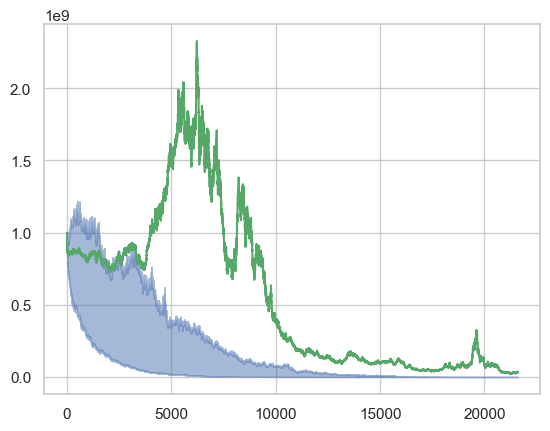

: 

In [ ]:
fig, axs = plt.subplots()
axs.plot(stats.index, stats["mean"], "g")
axs.fill_between(stats.index, stats["25%"], stats["75%"], color="b", alpha=0.5)